# graph_3_reg_04_06_w_01 Simulator with fixed init points 

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/measurements/simulator_init/master_thesis_qaoa'))

In [2]:
import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

from helpers import *
from shared.QiskitMaxcut import *
from shared.graph_helper import *

In [3]:
#%load_ext autoreload
#%autoreload 2

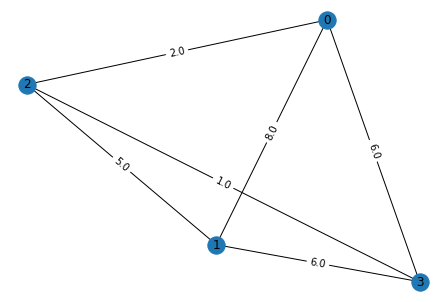

In [4]:
# ---- Define graph and MaxCut ----
filename = "graph_3_reg_04_06_w_01.txt"
graph = load_nx_graph_from(f"../data/{filename}")
opt_max_cut = -get_max_cut(graph.name)
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

### Goemans Williamson Solution

In [5]:
optimizer = GoemansWilliamsonOptimizer(5)
result = optimizer.solve(max_cut_qubo)
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

optimal function value: 20.0
optimal value: [0 1 0 1]
status: SUCCESS
0100: value: -19.000, probability: 50.0%
0101: value: -20.000, probability: 50.0%
Expectation Value: -19.5
Highest Exp.Value: -19 with 50.0 %
Lowest Exp.Value: -20 with 50.0 %
Highest Probability: -20 with 50.0 %
Ratio r: 0.5
Approiximation ratio: 0.975
MSE: 0.25
RMSE: 0.5


## Parameters

In [6]:
BACKEND, EVAL_NUM, MAX_ITER, MAX_P, SHOTS, initial_points = load_configs(graph.name)
display_configs()
all_results = {}

Backend = Simulator
EVAL_NUM = 50
MAX_ITER = 0
MAX_P = 4
SHOTS = 1024
Initial_Points = [array([-2.6072489 ,  4.09683645]), array([-3.40186785,  2.28061272,  5.75356476, -1.10844472]), array([ 3.65033485,  5.37269681,  0.39263765, -1.78727933,  0.64890894,
        0.45923593]), array([-5.70082804, -2.00474185,  2.53676052,  1.01981993,  2.15783159,
        3.68665365,  4.92940721, -0.44183973])]


## QAOA

In [7]:
from helpers.qaoa_helper import *

In [8]:
qaoa_p_means = []
qaoa_p_ratios = []
qaoa_p_approx_ratios = []

for p in range(1,MAX_P+1):
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, maxiter=MAX_ITER, init_points=initial_points[p-1])
    qaoa_p_means.append(m)
    qaoa_p_ratios.append(r)
    qaoa_p_approx_ratios.append(ar)

all_results["QAOA"] = [qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios]

p=1: ..................................................
p=2: ..................................................
p=3: ..................................................
p=4: ..................................................


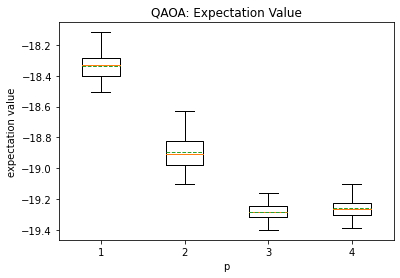

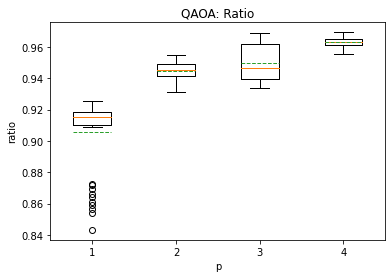

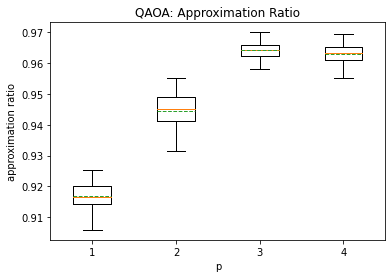

In [9]:
display_boxplots_results(qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios)

## QAOA with TQA

In [10]:
from helpers.qaoa_helper import *

In [11]:
tqa_p_means = []
tqa_p_ratios = []
tqa_p_approx_ratios = []
tqa_init_points = []

for p in range(1,MAX_P+1):
    tqa_initial_points = calculate_tqa(graph, p)
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, init_points=tqa_initial_points, maxiter=MAX_ITER)
    tqa_p_means.append(m)
    tqa_p_ratios.append(r)
    tqa_p_approx_ratios.append(ar)
    tqa_init_points.append(tqa_initial_points)
    
all_results["TQA QAOA"] = [tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, tqa_init_points]

TQA: Beta: [0.40703518], Gamma: [0.40703518] (p=1)
p=1: ..................................................
TQA: Beta: [0.68234925 0.22744975], Gamma: [0.22744975 0.68234925] (p=2)
p=2: ..................................................
TQA: Beta: [0.91387493 0.54832496 0.18277499], Gamma: [0.18277499 0.54832496 0.91387493] (p=3)
p=3: ..................................................
TQA: Beta: [0.99448807 0.71034862 0.42620917 0.14206972], Gamma: [0.14206972 0.42620917 0.71034862 0.99448807] (p=4)
p=4: ..................................................


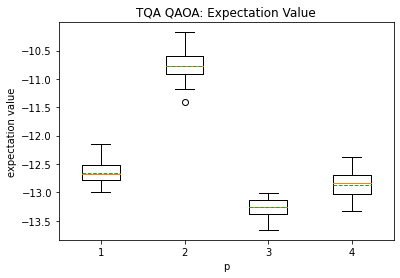

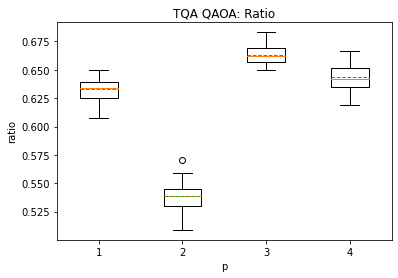

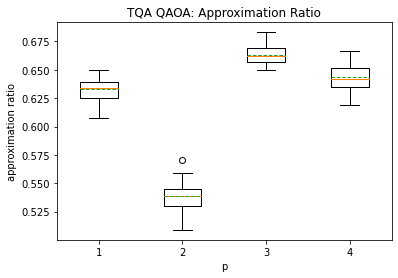

In [12]:
display_boxplots_results(tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, prefix='TQA ')

## WarmStart QAOA

In [13]:
from helpers.warmstart_helper import *

In [14]:
ws_p_means = []
ws_p_ratios = []
ws_p_approx_ratios = []
ws_opt_epsilons = []

for p in range(1,MAX_P+1):
    opt_epsilon = 0.25
    m, r, ar = start_ws_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, epsilon=opt_epsilon, maxiter=MAX_ITER)
    ws_p_means.append(m)
    ws_p_ratios.append(r)
    ws_p_approx_ratios.append(ar)
    ws_opt_epsilons.append(opt_epsilon)
    
all_results["WarmStart QAOA"] = [ws_p_means, ws_p_ratios, ws_p_approx_ratios, ws_opt_epsilons]

p=1: ..................................................
p=2: ..................................................
p=3: ..................................................
p=4: ..................................................


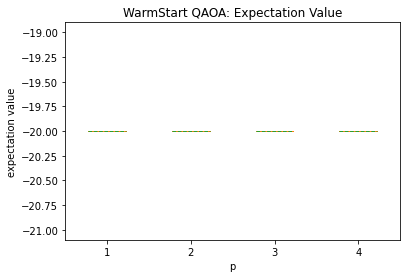

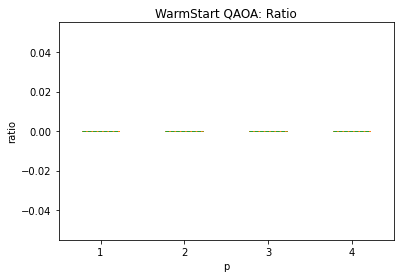

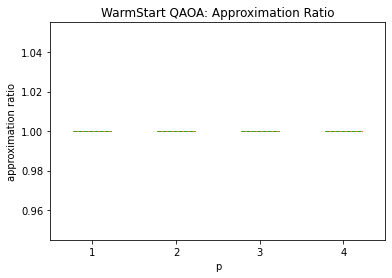

In [15]:
display_boxplots_results(ws_p_means, ws_p_ratios, ws_p_approx_ratios, prefix='WarmStart ')

### Recursive QAOA

In [16]:
from helpers.recursive_qaoa_helper import *

In [17]:
recursive_p_means = []
recursive_p_ratios = []
recursive_p_approx_ratios = []

for p in range(1,MAX_P+1):
    m, r, ar = start_recursive_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, maxiter=MAX_ITER, init_points=initial_points[p-1])
    recursive_p_means.append(m)
    recursive_p_ratios.append(r)
    recursive_p_approx_ratios.append(ar)

all_results["Recursive QAOA"] = [recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios]

p=1: ..................................................
p=2: ..................................................
p=3: ..................................................
p=4: ..................................................


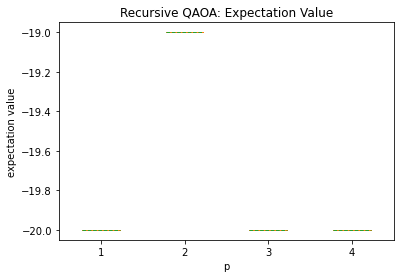

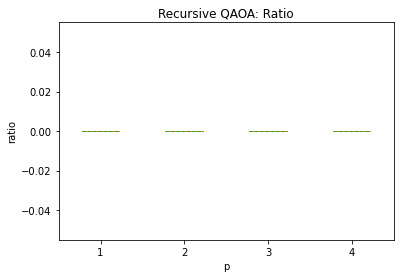

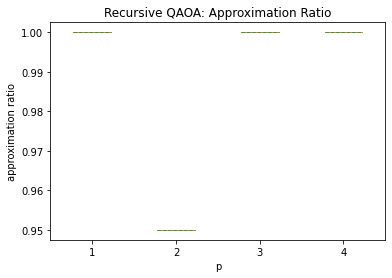

In [18]:
display_boxplots_results(recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios, prefix='Recursive ')

### Recursive WarmStart QAOA

In [19]:
from helpers.recursive_ws_helper import *

In [ ]:
ws_recursive_p_means = []
ws_recursive_p_ratios = []
ws_recursive_p_approx_ratios = []

for p in range(1,MAX_P+1):
    opt_epsilon = ws_opt_epsilons[p-1]
    m, r, ar = start_recursive_ws_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, epsilon=opt_epsilon, maxiter=MAX_ITER)
    ws_recursive_p_means.append(m)
    ws_recursive_p_ratios.append(r)
    ws_recursive_p_approx_ratios.append(ar)
    
all_results["Recursive WarmStart QAOA"] = [ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, ws_opt_epsilons]

p=1: ..................................................
p=2: ..................................................
p=3: ..................................................
p=4: .......................................

In [ ]:
display_boxplots_results(ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, prefix='Recursive WarmStart ')

## Results

In [ ]:
from helpers.results_helper import *

In [ ]:
means_df, ratio_df, approx_ratios_df = generate_dataframes(all_results)

### Metric Mean

In [ ]:
means_df

### Metric Ratio 

In [ ]:
ratio_df

### Metric Approximation Ratio

In [ ]:
approx_ratios_df

In [ ]:
# Save results 
filename = f'comparison_{BACKEND.name}_{graph.name}_results.npy'
with open(filename, 'wb') as f:
    np.save(f, all_results)
    print(f"Saved results to {filename}")

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table